In [204]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import seaborn as sns

In [205]:
os.chdir("D:\\ML_project\\")

In [206]:
os.getcwd()

'D:\\ML_project'

In [207]:
testing_dates = pd.date_range(start='2017-01-01', end='2024-04-01')

## 預測目標：Platts LNG Japan/Korea Spot Crg，收益率

"Platts LNG Japan/Korea Spot Crg" 很可能指的是 S&P Global Platts 提供的关于液化天然气（LNG）在日本和韩国现货市场的价格指数。"Crg" 可能是 "Cargo" 的缩写，意味着这个指数跟踪的是运往或在这两个国家现货市场交易的LNG货物的价格。

S&P Global Platts 是一家知名的能源和商品信息提供商，专注于提供市场数据、价格评估、分析和新闻。在LNG市场，Platts的价格指数被广泛用作交易、基准定价和市场分析的工具。

这个指数特别有价值，因为日本和韩国是全球最大的液化天然气进口国，他们的进口价格通常被视为亚洲LNG市场的重要参考。这些价格通常是根据各种因素计算的，包括供需状况、运输成本以及其他影响市场的宏观经济因素。

期貨價格

In [208]:
price_df = pd.read_parquet(".\\FE5225_LNG_ML\\data\\Bloomberg Data Retrive.parquet")
price_df['Date'] = pd.to_datetime(price_df.Date)
price_df = price_df[(price_df['Date'].isin(testing_dates)) & (price_df['Name']=='PLLFLNJK PLDP Index')].reset_index(drop=True)
price_df = price_df.sort_values(by='Date')
price_df.head(3)

,Date,last_price,VOLUME,PX_ASK,PX_BID,PX_SETTLE,OPEN_INT,Name
0,2017-01-03,9.75,0.0,NaN,NaN,NaN,NaN,PLLFLNJK PLDP Index
871200,2017-01-03,9.75,0.0,NaN,NaN,NaN,NaN,PLLFLNJK PLDP Index
148830,2017-01-03,9.75,0.0,NaN,NaN,NaN,NaN,PLLFLNJK PLDP Index


### ??為什麼這麼多列重複

In [209]:
price_df = price_df.drop_duplicates()
price_df.head(3)

,Date,last_price,VOLUME,PX_ASK,PX_BID,PX_SETTLE,OPEN_INT,Name
0,2017-01-03,9.75,0.0,NaN,NaN,NaN,NaN,PLLFLNJK PLDP Index
161536,2017-01-04,9.75,0.0,NaN,NaN,NaN,NaN,PLLFLNJK PLDP Index
12707,2017-01-05,9.75,0.0,NaN,NaN,NaN,NaN,PLLFLNJK PLDP Index


價格走勢圖

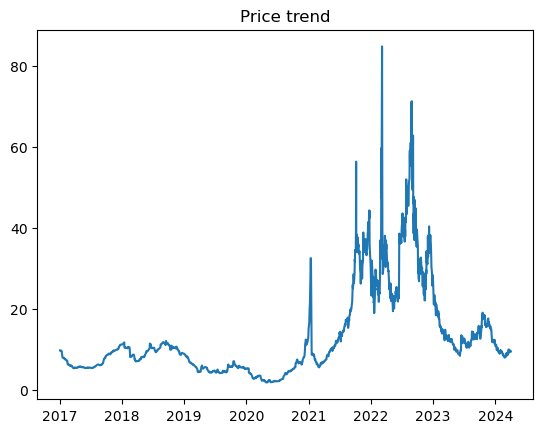

In [210]:
plt.plot(price_df['Date'], price_df['last_price'])
plt.title("Price trend")
plt.show()

收益率

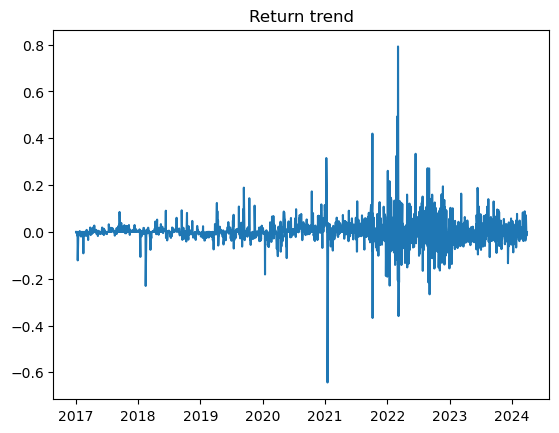

In [211]:
price_df['return'] = price_df['last_price'].shift(-1)/price_df['last_price'] - 1 # 收益率計算
plt.plot(price_df['Date'], price_df['return'])
plt.title('Return trend')
plt.show()

收益率分佈圖，感覺極值挺多

c:\Users\dctp_\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


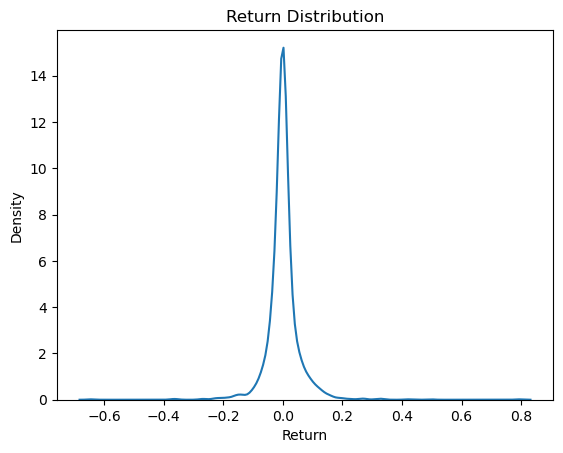

In [212]:
sns.kdeplot(price_df['return'].dropna())
plt.title('Return Distribution')
plt.xlabel('Return')
plt.ylabel('Density')
plt.show()

## 特征1：價格方面的因子

過去5個、20個、90個、150個工作日的收益率均值| 注意不要用到未來數據

In [213]:
price_df['return_5d'] = price_df['return'].rolling(window=5).mean().shift(1)
price_df['return_20d'] = price_df['return'].rolling(window=20).mean().shift(1)
price_df['return_90d'] = price_df['return'].rolling(window=90).mean().shift(1)
price_df['return_150d'] = price_df['return'].rolling(window=150).mean().shift(1)

過去5個、20個、90個、150個工作日的收益率波動率

In [214]:
price_df['return_vol_5d'] = price_df['return'].rolling(window=5).var().shift(1)
price_df['return_vol_20d'] = price_df['return'].rolling(window=20).var().shift(1)
price_df['return_vol_90d'] = price_df['return'].rolling(window=90).var().shift(1)
price_df['return_vol_150d'] = price_df['return'].rolling(window=150).var().shift(1)

## 特征2：Inventories

Daily inventories (by installation)：-zeebrugge代表了不同地理位置的天然气库存水平

比如：Cameron (Liqu.): “Cameron”可能是指Cameron LNG出口终端，位于美国路易斯安那州，而“(Liqu.)”可能表明这列数据是关于液化天然气的

Capacity (Nm3): 这列可能是指某个设施或安装的总存储容量，用立方米（Nm3）来衡量。

Capacity Utilization (%): 这表示已使用的存储容量的百分比。容量利用率可以表明设施多大程度上正在使用其最大存储能力。

Cargo (Nm3): “Cargo”通常指的是货物或商品，这里可能特指储存或运输的天然气量，同样以立方米计量。

Send-in (Nm3): 这表示在特定时间段内送入设施的天然气量。

Send-out (Nm3): 与“Send-in”相对，这表示在特定时间段内从设施送出的天然气量。

In [215]:
inv_by_install = pd.read_excel(".\\FE5225_LNG_ML\\data\\Physical Data\\Daily inventories (by installation).xlsx")
inv_by_install['date'] = pd.to_datetime(inv_by_install.date)
inv_by_insatll = inv_by_install[inv_by_install['date'].isin(testing_dates)]
inv_by_install.head(3)

,date,Level (Nm3),APLNG,Barcelona,Bilbao,Brunsbüttel FSRU,Calcasieu Pass,Cameron (Liqu.),Cartagena (ESP),Corpus Christi,...,South Hook,Swinoujscie,Toscana,Wilhelmshaven GasPort,Zeebrugge,Capacity (Nm3),Capacity Utilization (%),Cargo (Nm3),Send-in (Nm3),Send-out (Nm3)
0,2017-01-01,2603110773,NaN,102282088,120468438,NaN,0.0,0.0,127371257,NaN,...,280546004,115121594,51838806,NaN,22833148,7179061948,36.259762,-57417476,40232660,77140958
1,2017-01-02,2548762422,NaN,170489751,113042583,NaN,0.0,0.0,123435354,NaN,...,271896496,111528291,51827957,NaN,20948277,7179061948,35.502722,9466609,39118068,102077099
2,2017-01-03,2616266042,NaN,165487791,103163141,NaN,0.0,0.0,118848511,NaN,...,256405837,104769935,51811398,NaN,87875187,7179061948,36.443007,166306605,39118068,108952510


In [216]:
inv_by_country = pd.read_excel(".\\FE5225_LNG_ML\\data\\Physical Data\\LNG Daily inventories (by country).xlsx")
inv_by_country['date'] = pd.to_datetime(inv_by_country.date)
inv_by_country = inv_by_country[inv_by_country['date'].isin(testing_dates)]
inv_by_country.head(3)


,date,Level (Nm3),Australia,Belgium,Croatia,France,Germany,Greece,Italy,Lithuania,...,Poland,Portugal,Spain,United Kingdom,United States,Capacity (Nm3),Capacity Utilization (%),Cargo (Nm3),Send-in (Nm3),Send-out (Nm3)
0,2017-01-01,2603110773,NaN,22833148,NaN,155699709,NaN,39972855,121873098,89666985,...,115121594,160749062,662663201,739720793,378498199.0,7179061948,36.259762,-57417476,40232660,77140958
1,2017-01-02,2548762422,NaN,20948277,NaN,146719592,NaN,33499428,113857400,87895743,...,111528291,155055050,693762716,728392153,341182778.0,7179061948,35.502722,9466609,39118068,102077099
2,2017-01-03,2616266042,NaN,87875187,NaN,218393225,NaN,26869547,107283477,77689118,...,104769935,142971548,644387204,710288598,380301417.0,7179061948,36.443007,166306605,39118068,108952510


只用inventories這個數據

In [217]:
inv = pd.read_excel(".\\FE5225_LNG_ML\\data\\Physical Data\\LNG Daily inventories.xlsx")
inv['date'] = pd.to_datetime(inv.date)
inv = inv[inv['date'].isin(testing_dates)]
inv = inv.sort_values(by='date')
inv = inv.set_index('date')
inv.head(3)

,Level (Nm3),Capacity (Nm3),Capacity Utilization (%),Cargo (Nm3),Send-in (Nm3),Send-out (Nm3)
date,,,,,,
2017-01-01,2603110773,7179061948,36.259762,-57417476,40232660,77140958
2017-01-02,2548762422,7179061948,35.502722,9466609,39118068,102077099
2017-01-03,2616266042,7179061948,36.443007,166306605,39118068,108952510


In [218]:
#加入變化率
for col in list(inv.columns)[1:]:
    inv[f'{col}_rate'] = inv[col]/inv[col].shift(1)-1
inv.head(3)

,Level (Nm3),Capacity (Nm3),Capacity Utilization (%),Cargo (Nm3),Send-in (Nm3),Send-out (Nm3),Capacity (Nm3)_rate,Capacity Utilization (%)_rate,Cargo (Nm3)_rate,Send-in (Nm3)_rate,Send-out (Nm3)_rate
date,,,,,,,,,,,
2017-01-01,2603110773,7179061948,36.259762,-57417476,40232660,77140958,NaN,NaN,NaN,NaN,NaN
2017-01-02,2548762422,7179061948,35.502722,9466609,39118068,102077099,0.0,-0.020878,-1.164873,-0.027704,0.323254
2017-01-03,2616266042,7179061948,36.443007,166306605,39118068,108952510,0.0,0.026485,16.567706,0.000000,0.067355


In [219]:
#inv_sin = pd.read_excel(".\\FE5225_LNG_ML\\data\\Physical Data\\LNG Daily inventories-sin-tra23009.xlsx")
#inv_sin['date'] = pd.to_datetime(inv_sin.date)
#inv_sin = inv_sin[inv_sin['date'].isin(testing_dates)]
#inv_sin

#same as above


## 特征3：出口

總出口

In [220]:
exports = pd.read_excel(".\\FE5225_LNG_ML\\data\\Physical Data\\World daily exports — 2024-04-04 15h05.xlsx")
exports['date'] = pd.to_datetime(exports.date)
exports = exports[exports['date'].isin(testing_dates)]
exports = exports.rename(columns={'Total':'total_exports'})

exports = exports.sort_values(by='date')
exports = exports.set_index('date')
# 加入變化率
exports['total_exports_rate'] = exports['total_exports']/exports['total_exports'].shift(1)-1
exports.head(3)


,total_exports,total_exports_rate
date,,
2017-01-01,1556735,NaN
2017-01-02,1857938,0.193484
2017-01-03,1425050,-0.232994


根據國家分類(Taiwan belongs to CN)

In [221]:
exports_by_des = pd.read_excel(".\\FE5225_LNG_ML\\data\\Physical Data\\World daily exports (by destination country) — 2024-04-04 15h07.xlsx")
exports_by_des['date'] = pd.to_datetime(exports_by_des.date)
exports_by_des = exports_by_des[exports_by_des['date'].isin(testing_dates)]
exports_by_des = exports_by_des.sort_values(by='date')
exports_by_des.set_index('date',inplace=True)
exports_by_des.head(3)

,Japan,South Korea,China,India,Spain,Taiwan,France,United Kingdom,Turkey,Italy,...,Gibraltar,Australia,Russian Federation,Denmark,Vietnam,Papua New Guinea,Cuba,Bahrain,Estonia,Iceland
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,707551,413220,0,0,55912,140650,0,0,209714,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-02,373037,253175,403520,131945,267720,0,0,0,294654,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-03,585686,210490,0,280650,0,141329,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [222]:
# 只看日本，韓國的數據及變化率
exports_by_des = exports_by_des.iloc[:,:2]
for col in list(exports_by_des.columns):
    exports_by_des[f'{col}_rate'] = exports_by_des[col]/exports_by_des[col].shift(1)-1
exports_by_des.head(3)


,Japan,South Korea,Japan_rate,South Korea_rate
date,,,,
2017-01-01,707551,413220,NaN,NaN
2017-01-02,373037,253175,-0.472777,-0.387312
2017-01-03,585686,210490,0.570048,-0.168599


In [223]:
exports_by_des.columns = ['exports_' + col for col in exports_by_des.columns]

根據地區

In [224]:
exports_by_des_trading = pd.read_excel(".\\FE5225_LNG_ML\\data\\Physical Data\\World daily exports (by destination trading region) — 2024-04-04 15h06.xlsx")
exports_by_des_trading['date'] = pd.to_datetime(exports_by_des_trading.date)
exports_by_des_trading = exports_by_des_trading[exports_by_des_trading['date'].isin(testing_dates)]
exports_by_des_trading = exports_by_des_trading.sort_values(by='date')
exports_by_des_trading.set_index('date',inplace=True)
exports_by_des_trading.head(3)


,Eastern Asia,North West Europe Zone,MED Zone (MED Sea+Black Sea),South-Central Asia,Latin America,South-East Asia,Mideast Gulf,USEC (US East Coast),Other North Africa,Other Middle East,East Coast Canada,USGC (US Gulf Coast),Unknown,Oceania,Northern Russia,Other Southern Europe
date,,,,,,,,,,,,,,,,
2017-01-01,1261421,0,295314,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-01-02,1029732,0,562374,131945,0,0,0,133887,0,0,0,0,0,0,0,0
2017-01-03,937505,0,73235,280650,0,0,0,0,133660,0,0,0,0,0,0,0


In [225]:
# 只看東亞
exports_by_des_trading = exports_by_des_trading.iloc[:,:1]
exports_by_des_trading['Eastern Asia_rate'] = exports_by_des_trading['Eastern Asia']/exports_by_des_trading['Eastern Asia'].shift(1)-1
exports_by_des_trading.columns = ['exports_' + col for col in exports_by_des_trading.columns]
exports_by_des_trading.head(3)

,exports_Eastern Asia,exports_Eastern Asia_rate
date,,
2017-01-01,1261421,NaN
2017-01-02,1029732,-0.183673
2017-01-03,937505,-0.089564


根據路線，這個不用了

In [226]:
exports_by_route = pd.read_excel(".\\FE5225_LNG_ML\\data\\Physical Data\\World daily exports (by route) — 2024-04-04 15h10.xlsx")
exports_by_route['date'] = pd.to_datetime(exports_by_route.date)
exports_by_route = exports_by_route[exports_by_route['date'].isin(testing_dates)]
exports_by_route.head(3)

,date,Other Routes,Via Suez Canal,Via Panama Canal,Via Northern Sea Route,Via Panama Canal and Suez Canal
1310,2017-01-01,1206371,209714,140650,0,0
1311,2017-01-02,1724078,133860,0,0,0
1312,2017-01-03,1425050,0,0,0,0


## 特征4：進口

根據國家分

In [227]:
imports_by_des = pd.read_excel(".\\FE5225_LNG_ML\\data\\Physical Data\\World daily imports (by destination country) — 2024-04-04 15h11.xlsx")
imports_by_des['date'] = pd.to_datetime(imports_by_des.date)
imports_by_des = imports_by_des[imports_by_des['date'].isin(testing_dates)]
imports_by_des = imports_by_des.sort_values(by='date')
imports_by_des.set_index('date', inplace=True)
imports_by_des.head(3)

,Japan,South Korea,China,India,Spain,Taiwan,France,United Kingdom,Turkey,Italy,...,Gibraltar,Australia,Russian Federation,Denmark,Vietnam,Papua New Guinea,Cuba,Bahrain,Estonia,Iceland
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,467765.0,129776,149487.0,0.0,0.0,0.0,0,0.0,121431.0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-02,682954.0,531228,0.0,0.0,141504.0,0.0,142100,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-03,438601.0,419458,304527.0,0.0,0.0,0.0,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0


In [228]:
# 只看日韓, 記錄一下變化率
imports_by_des = imports_by_des.iloc[:,:2]
for col in imports_by_des.columns:
    imports_by_des[f'{col}_rate'] = imports_by_des[col]/imports_by_des[col].shift(1)-1
imports_by_des.columns = ['imports_' + col for col in imports_by_des.columns]
imports_by_des.head(3)

,imports_Japan,imports_South Korea,imports_Japan_rate,imports_South Korea_rate
date,,,,
2017-01-01,467765.0,129776,NaN,NaN
2017-01-02,682954.0,531228,0.460037,3.093423
2017-01-03,438601.0,419458,-0.357788,-0.210399


根據地區

In [229]:
imports_by_des_trading = pd.read_excel(".\\FE5225_LNG_ML\\data\\Physical Data\\World daily imports (by destination trading region) — 2024-04-04 15h12.xlsx")
imports_by_des_trading['date'] = pd.to_datetime(imports_by_des_trading.date)
imports_by_des_trading = imports_by_des_trading[imports_by_des_trading['date'].isin(testing_dates)]
imports_by_des_trading = imports_by_des_trading.sort_values('date').set_index('date')

imports_by_des_trading.head(3)


,Eastern Asia,North West Europe Zone,MED Zone (MED Sea+Black Sea),South-Central Asia,Latin America,South-East Asia,Mideast Gulf,USEC (US East Coast),Other North Africa,Other Middle East,East Coast Canada,USGC (US Gulf Coast),Unknown,Oceania,Northern Russia,Other Southern Europe
date,,,,,,,,,,,,,,,,
2017-01-01,747028,0.0,121431.0,0.0,0,0.0,0.0,131136,0,147726,0,0,0,0,0,0
2017-01-02,1214182,300190.0,141504.0,0.0,263408,0.0,0.0,0,152323,0,0,0,0,0,0,0
2017-01-03,1162586,0.0,0.0,140939.0,0,0.0,0.0,143576,0,0,0,0,0,0,0,0


In [230]:
# 只要東亞
imports_by_des_trading = imports_by_des_trading.iloc[:,:1]
for col in imports_by_des_trading.columns:
    imports_by_des_trading[f"{col}_rate"] = imports_by_des_trading[col]/imports_by_des_trading[col].shift(1)-1
imports_by_des_trading.columns = ['imports_' + col for col in imports_by_des_trading.columns]
imports_by_des_trading.head(3) 

,imports_Eastern Asia,imports_Eastern Asia_rate
date,,
2017-01-01,747028,NaN
2017-01-02,1214182,0.625350
2017-01-03,1162586,-0.042494


港口，不用了

In [231]:
imports_by_origin_port = pd.read_excel(".\\FE5225_LNG_ML\\data\\Physical Data\\World daily imports (by origin port) — 2024-04-04 15h10.xlsx")
imports_by_origin_port['date'] = pd.to_datetime(imports_by_origin_port.date)
imports_by_origin_port = imports_by_origin_port[imports_by_origin_port['date'].isin(testing_dates)]
imports_by_origin_port.head(3)

,date,Ras Laffan,Bintulu,Dampier,Bonny Island,Point Fortin,Gladstone,Sabine Pass Liq.,Arzew,Prigorodnoye,...,Gyeongsangnam,Europoort Light. 3,NFE Altamira FLNG Terminal,Vlissingen,Westpoort,ICO Zeebrugge Terminal,Gibraltar LNG Terminal,Loudden,Viking Line - Stadsgårdsleden,Yangshan
3288,2017-01-01,127989.0,138663.0,129123,131136.0,0.0,0,0.0,121431.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3289,2017-01-02,564315.0,372269.0,131537,448338.0,263408.0,0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3290,2017-01-03,268986.0,0.0,308479,0.0,143576.0,284465,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


路線，不用了

In [232]:
imports_by_route = pd.read_excel(".\\FE5225_LNG_ML\\data\\Physical Data\\World daily imports (by route) — 2024-04-04 15h10.xlsx")
imports_by_route['date'] = pd.to_datetime(imports_by_route.date)
imports_by_route = exports_by_route[imports_by_route['date'].isin(testing_dates)]
imports_by_route.head(3)

C:\Users\dctp_\AppData\Local\Temp\ipykernel_9152\715751825.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  imports_by_route = exports_by_route[imports_by_route['date'].isin(testing_dates)]


,date,Other Routes,Via Suez Canal,Via Panama Canal,Via Northern Sea Route,Via Panama Canal and Suez Canal
1310,2017-01-01,1206371,209714,140650,0,0
1311,2017-01-02,1724078,133860,0,0,0
1312,2017-01-03,1425050,0,0,0,0


按船隻分類，不用了

In [233]:
imports_by_vessel = pd.read_excel(".\\FE5225_LNG_ML\\data\\Physical Data\\World daily imports (by vessel type) — 2024-04-04 15h10.xlsx")
imports_by_vessel['date'] = pd.to_datetime(imports_by_vessel.date)
imports_by_vessel = imports_by_vessel[imports_by_vessel['date'].isin(testing_dates)]
imports_by_vessel.head(3)
imports_by_vessel = imports_by_vessel.set_index('date')

最後計算一下總進口

In [234]:
imports = imports_by_vessel.sum(axis=1)
imports = pd.DataFrame(imports).rename(columns={0:"total_imports"})
imports['total_imports_rate'] = imports['total_imports']/imports['total_imports'].shift(1)-1
imports.head(3)

,total_imports,total_imports_rate
date,,
2017-01-01,1147321.0,NaN
2017-01-02,2071607.0,0.805604
2017-01-03,1447101.0,-0.301460


## 特征5：擁堵情況

“World daily congestion count (load, discharge, by port)” 指的很可能是一个追踪全球各港口日常拥堵情况的指数或报告。

根據港口分類，不用

In [235]:
congestion_by_port = pd.read_excel(".\\FE5225_LNG_ML\\data\\Physical Data\\World daily congestion count (load, discharge, by port) — 2024-04-04 16h46.xlsx")
congestion_by_port['date'] = pd.to_datetime(congestion_by_port.date)
congestion_by_port = congestion_by_port[congestion_by_port['date'].isin(testing_dates)]
congestion_by_port.head(3)


,date,Ras Laffan,Pengerang,Bintulu,Pasir Gudang,Dampier,Geoje,Gibraltar LNG Terminal,Sabine Pass Liq.,Tanjung Bin,...,Teesside,Kollsnes,Gwangyang Anchorage,Shenzhen,Isle of Grain,Cadiz,Chevron Wheatstone,Melaka Anch.,Malta Light.,Sendai
0,2017-01-01,6,2,2,2,4,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2017-01-02,5,7,6,2,4,3,1,2,3,...,0,0,0,0,0,0,0,0,0,0
2,2017-01-03,9,4,6,2,4,3,0,1,3,...,0,0,0,0,0,0,0,0,0,0


根據等待狀態分類，不用

In [236]:
congestion_by_wait = pd.read_excel(".\\FE5225_LNG_ML\\data\\Physical Data\\World daily congestion count (load, discharge, by waiting status) — 2024-04-04 16h45.xlsx")
congestion_by_wait['date'] = pd.to_datetime(congestion_by_wait.date)
congestion_by_wait = congestion_by_wait[congestion_by_wait['date'].isin(testing_dates)]
congestion_by_wait.head(3)
congestion_by_wait.set_index('date',inplace=True)


加一個擁堵sum

In [237]:
congestion = pd.DataFrame(congestion_by_wait.sum(axis=1))
congestion.sort_index(inplace=True)
congestion = congestion.rename(columns={0:'congestion'})
congestion['congestion_rate'] = congestion['congestion']/congestion['congestion'].shift(1)-1
congestion.head(3)

,congestion,congestion_rate
date,,
2017-01-01,54,NaN
2017-01-02,82,0.518519
2017-01-03,91,0.109756


### on water 不知道是啥，不用了

In [238]:
on_water = pd.read_excel(".\\FE5225_LNG_ML\\data\\Physical Data\\Daily Commodities on water (by origin trading region) — 2024-04-04 16h42.xlsx")
on_water['date'] = pd.to_datetime(on_water.date)
on_water = on_water[on_water['date'].isin(testing_dates)]
on_water.head(3)


,date,USGC (US Gulf Coast),Mideast Gulf,Oceania,Western Africa,South-East Asia,Northern Russia,Latin America,MED Zone (MED Sea+Black Sea),Other Middle East,USEC (US East Coast),North West Europe Zone,Eastern Asia,Eastern Africa,Other North Africa,South-Central Asia,USWC (US West Coast),Unknown
0,2018-11-01,3.372102e+06,7.853680e+06,7.955591e+06,3.573100e+06,3.771544e+06,1.863238e+06,1.644161e+06,930820.221840,9.653676e+05,299976.245914,732603.638019,313509.126434,0.0,0.0,0.0,0,0
1,2018-11-02,3.203754e+06,7.720366e+06,7.389215e+06,3.440345e+06,4.009704e+06,1.864771e+06,1.776058e+06,797190.166769,1.106586e+06,299687.475794,583827.185048,313583.577004,0.0,0.0,0.0,0,0
2,2018-11-03,3.342175e+06,8.399524e+06,6.705508e+06,3.182868e+06,4.089332e+06,1.699306e+06,1.643587e+06,394736.511530,1.105020e+06,299398.984023,713148.311933,454207.205828,0.0,0.0,0.0,0,0


## 特征6：船只數

按類型分類，不用

In [239]:
vessel_count = pd.read_excel(".\\FE5225_LNG_ML\\data\\Physical Data\\Daily available vessel count (by vessel type) — 2024-04-04 16h47.xlsx")
vessel_count['date'] = pd.to_datetime(vessel_count.date)
vessel_count = vessel_count[vessel_count['date'].isin(testing_dates)]
vessel_count.head(3)


,date,XL (Upper Conventional),L (Lower Conventional),XS (Pressure Gas),Q-Flex,M (Med Max),Q-Max,S (Small Scale),Unknown
0,2017-01-01,253,142,23,31,15,14,9,3
1,2017-01-02,253,142,23,31,15,14,9,3
2,2017-01-03,253,142,23,31,15,14,9,3


直接用總數

In [240]:
vessel_count = vessel_count.set_index('date')
vessel_count = vessel_count.sort_index()

vessel_sum = pd.DataFrame(vessel_count.sum(axis=1))
vessel_sum = vessel_sum.rename(columns={0:'vessel_count_sum'})
vessel_sum['vessel_count_sum_rate'] = vessel_sum['vessel_count_sum']/vessel_sum['vessel_count_sum'].shift(1)-1
vessel_sum.head(3)

,vessel_count_sum,vessel_count_sum_rate
date,,
2017-01-01,490,NaN
2017-01-02,490,0.0
2017-01-03,490,0.0


In [241]:
#ballast_cap = pd.read_excel(".\\FE5225_LNG_ML\\data\\Physical Data\\World daily expected ballast capacity capacity (by source) — 2024-04-04 16h43.xlsx")
#ballast_cap['date'] = pd.to_datetime(ballast_cap.date)
#ballast_cap
#只有2024-04-04之後的數據，不考慮

船隻容量，直接求和

In [242]:
vessel_cap = pd.read_excel(".\\FE5225_LNG_ML\\data\\Physical Data\\World daily vessel capacity (by current continents) — 2024-04-04 16h51.xlsx")
vessel_cap['date'] = pd.to_datetime(vessel_cap.date)
vessel_cap = vessel_cap[vessel_cap['date'].isin(testing_dates)]
vessel_cap.head(3)


,date,Asia,Europe,Americas,Africa,Oceania,Unknown
0,2018-01-01,40321129,6010982,5185530,8836226,4463625,9839667
1,2018-01-02,42149959,5634216,5011589,8221110,4988305,8651980
2,2018-01-03,39802364,6678046,5389943,7522480,4864205,10572121


求和

In [243]:
vessel_cap = vessel_cap.set_index('date')
vessel_cap = vessel_cap.sort_index()

vessel_cap_sum = pd.DataFrame(vessel_cap.sum(axis=1))
vessel_cap_sum = vessel_cap_sum.rename(columns={0:'vessel_cap_sum'})
vessel_cap_sum['vessel_cap_sum_rate'] = vessel_cap_sum['vessel_cap_sum']/vessel_cap_sum['vessel_cap_sum'].shift(1)-1
vessel_cap_sum.head(3)

,vessel_cap_sum,vessel_cap_sum_rate
date,,
2018-01-01,74657159,NaN
2018-01-02,74657159,0.000000
2018-01-03,74829159,0.002304


## merge所有因子+label

In [244]:
price_df, 
inv, 
exports,exports_by_des,exports_by_des_trading,imports_by_des,imports_by_des_trading,imports,congestion,vessel_sum,vessel_cap_sum

(            total_exports  total_exports_rate
 date                                         
 2017-01-01        1556735                 NaN
 2017-01-02        1857938            0.193484
 2017-01-03        1425050           -0.232994
 2017-01-04        1799383            0.262681
 2017-01-05        2237584            0.243528
 ...                   ...                 ...
 2024-03-28        3458667            0.575869
 2024-03-29        2035783           -0.411397
 2024-03-30        2413977            0.185773
 2024-03-31        3056524            0.266178
 2024-04-01        2213825           -0.275705
 
 [2648 rows x 2 columns],
             exports_Japan  exports_South Korea  exports_Japan_rate  \
 date                                                                 
 2017-01-01         707551               413220                 NaN   
 2017-01-02         373037               253175           -0.472777   
 2017-01-03         585686               210490            0.570048   
 2017-

In [245]:
price_df = price_df.rename(columns={'Date':'date'})
price_df = price_df.set_index('date')
price_df = price_df.iloc[:,7:]
price_df

,return,return_5d,return_20d,return_90d,return_150d,return_vol_5d,return_vol_20d,return_vol_90d,return_vol_150d
date,,,,,,,,,
2017-01-03,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,-0.005128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-09,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2024-03-25,-0.016580,-0.001575,0.011198,-0.005100,-0.001482,0.001867,0.001553,0.001359,0.001781
2024-03-26,-0.014998,-0.005615,0.009348,-0.005730,-0.001610,0.001896,0.001586,0.001337,0.001782
2024-03-27,-0.001470,-0.001221,0.007892,-0.005945,-0.001831,0.001648,0.001614,0.001337,0.001781


In [246]:
from functools import reduce

dfs = [price_df,inv,exports,exports_by_des,exports_by_des_trading,imports_by_des,imports_by_des_trading,imports,congestion,vessel_sum,vessel_cap_sum]

df = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how='left'), dfs)
df


,return,return_5d,return_20d,return_90d,return_150d,return_vol_5d,return_vol_20d,return_vol_90d,return_vol_150d,Level (Nm3),...,imports_Eastern Asia,imports_Eastern Asia_rate,total_imports,total_imports_rate,congestion,congestion_rate,vessel_count_sum,vessel_count_sum_rate,vessel_cap_sum,vessel_cap_sum_rate
date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2616266042,...,1162586,-0.042494,1447101.0,-0.301460,91,0.109756,490,0.000000,NaN,NaN
2017-01-04,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2472657829,...,1387831,0.193745,1672421.0,0.155704,91,0.000000,490,0.000000,NaN,NaN
2017-01-05,-0.005128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2463584639,...,1348985,-0.027990,2023559.0,0.209958,96,0.054945,490,0.000000,NaN,NaN
2017-01-06,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2429864234,...,1678614,0.244353,2367920.0,0.170176,98,0.020833,491,0.002041,NaN,NaN
2017-01-09,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2537470326,...,927275,0.042991,1529089.0,0.461454,101,0.052083,491,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-25,-0.016580,-0.001575,0.011198,-0.005100,-0.001482,0.001867,0.001553,0.001359,0.001781,4201802283,...,1170315,1.071394,2651729.0,0.514985,119,0.017094,796,0.000000,117258682.0,0.000000
2024-03-26,-0.014998,-0.005615,0.009348,-0.005730,-0.001610,0.001896,0.001586,0.001337,0.001782,4151696462,...,1663166,0.421127,2955375.0,0.114509,121,0.016807,796,0.000000,117258682.0,0.000000
2024-03-27,-0.001470,-0.001221,0.007892,-0.005945,-0.001831,0.001648,0.001614,0.001337,0.001781,4063066413,...,1832070,0.101556,2914482.0,-0.013837,131,0.082645,796,0.000000,117258682.0,0.000000


df說明：return是預測目標，表示下一天的收益率. _rate是對應因子的變化率

In [247]:
df.to_parquet(".\\training_df.parquet")